<a href="https://colab.research.google.com/github/Fragoa/Regularizing-Neural-Networks/blob/main/Regularizing_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Data Peprocessing

In [2]:
# Load full MNIST dataset
(x_train_full, y_train_full), (x_test, y_test) = keras.datasets.mnist.load_data()

x_all = np.concatenate([x_train_full, x_test])
y_all = np.concatenate([y_train_full, y_test])

# Normalize pixel values to [0, 1]
x_all = x_all.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

In [3]:
# Select ~5% of the total data for training + validation
x_half, _, y_half, _ = train_test_split(x_all, y_all, test_size=0.5, random_state=42)

# Split tiny set into training and validation sets (80/20 split)
x_train, x_val, y_train, y_val = train_test_split(x_half, y_half, test_size=0.2, random_state=42)

# Reshape inputs to (batch_size, 784) for dense layers
x_train = x_train.reshape(-1, 784)
x_val   = x_val.reshape(-1, 784)
x_test  = x_test.reshape(-1, 784)

# Training Models

## **M1**

In [4]:
def build_model_M1():
    model = keras.Sequential([
        layers.Dense(8, activation='relu', input_shape=(784,)),
        layers.Dense(16, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [5]:
model_M1 = build_model_M1()
history_M1 = model_M1.fit(x_train, y_train,
                          epochs=50,
                          batch_size=32,
                          validation_data=(x_val, y_val),
                          verbose=0)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [6]:
# Extract metrics
train_acc_M1 = history_M1.history['accuracy'][-1]
val_acc_M1 = history_M1.history['val_accuracy'][-1]
train_loss_M1 = history_M1.history['loss'][-1]
val_loss_M1 = history_M1.history['val_loss'][-1]

# Evaluate on test set
test_loss_M1, test_acc_M1 = model_M1.evaluate(x_test, y_test, verbose=0)

# Print results
print("\n M1 (No Regularization) Results:")
print(f"   - Train Accuracy:       {train_acc_M1:.4f}")
print(f"   - Train Loss:           {train_loss_M1:.4f}")
print(f"   - Validation Accuracy:  {val_acc_M1:.4f}")
print(f"   - Validation Loss:      {val_loss_M1:.4f}")
print(f"   - Test Accuracy:        {test_acc_M1:.4f}")
print(f"   - Test Loss:            {test_loss_M1:.4f}")

# Overfitting check
if train_acc_M1 - val_acc_M1 > 0.05:
    print(" Likely overfitting detected.")
else:
    print(" No significant overfitting.")


 M1 (No Regularization) Results:
   - Train Accuracy:       0.9460
   - Train Loss:           0.1823
   - Validation Accuracy:  0.9146
   - Validation Loss:      0.3121
   - Test Accuracy:        0.9308
   - Test Loss:            0.2455
 No significant overfitting.


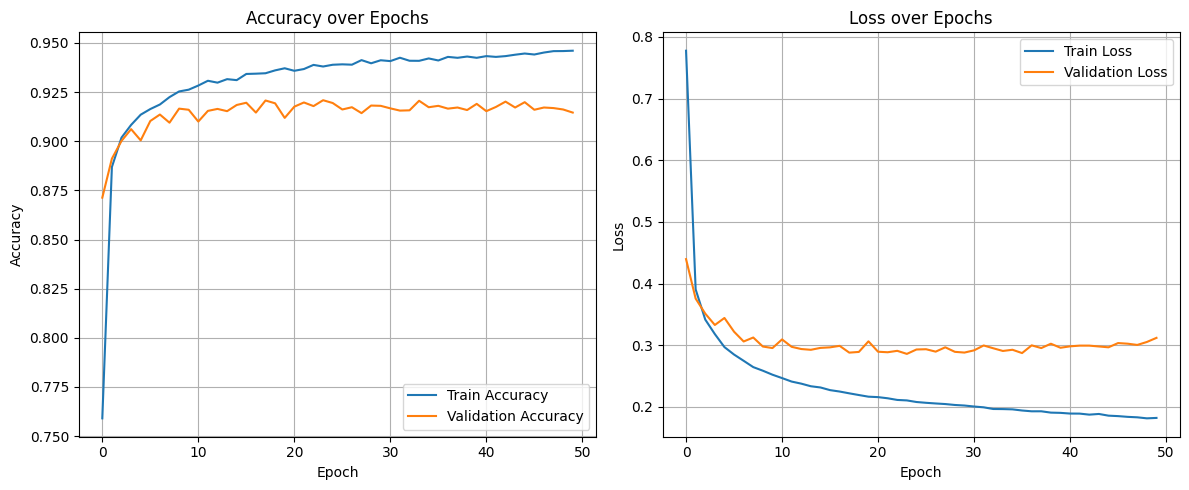

In [7]:
# Plot Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_M1.history['accuracy'], label='Train Accuracy')
plt.plot(history_M1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history_M1.history['loss'], label='Train Loss')
plt.plot(history_M1.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## **M1-L1**

In [8]:
def build_model_M1_L1(l1_lambda):
    model = keras.Sequential([
        layers.Dense(8, activation='relu', input_shape=(784,),
                     kernel_regularizer=regularizers.l1(l1_lambda)),
        layers.Dense(16, activation='relu',
                     kernel_regularizer=regularizers.l1(l1_lambda)),
        layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [9]:
lambda_val = 1e-7
model_M1_L1 = build_model_M1_L1(lambda_val)
history_M1_L1 = model_M1_L1.fit(x_train, y_train,
                                epochs=50,
                                batch_size=32,
                                validation_data=(x_val, y_val),
                                verbose=0)


In [10]:
# Evaluate on test set
test_loss, test_acc = model_M1_L1.evaluate(x_test, y_test, verbose=0)

# Extract final metrics
train_acc = history_M1_L1.history['accuracy'][-1]
val_acc = history_M1_L1.history['val_accuracy'][-1]
train_loss = history_M1_L1.history['loss'][-1]
val_loss = history_M1_L1.history['val_loss'][-1]

# Print results
print(f"\n Final Results of M1-L1 (λ = {lambda_val}):")
print(f"   - Train Accuracy:       {train_acc:.4f}")
print(f"   - Train Loss:           {train_loss:.4f}")
print(f"   - Validation Accuracy:  {val_acc:.4f}")
print(f"   - Validation Loss:      {val_loss:.4f}")
print(f"   - Test Accuracy:        {test_acc:.4f}")
print(f"   - Test Loss:            {test_loss:.4f}")

# Overfitting check
if train_acc - val_acc > 0.05:
    print(" Overfitting is likely present.")
else:
    print("\ No significant overfitting.")



 Final Results of M1-L1 (λ = 1e-07):
   - Train Accuracy:       0.9567
   - Train Loss:           0.1419
   - Validation Accuracy:  0.9263
   - Validation Loss:      0.2732
   - Test Accuracy:        0.9456
   - Test Loss:            0.1987
\ No significant overfitting.


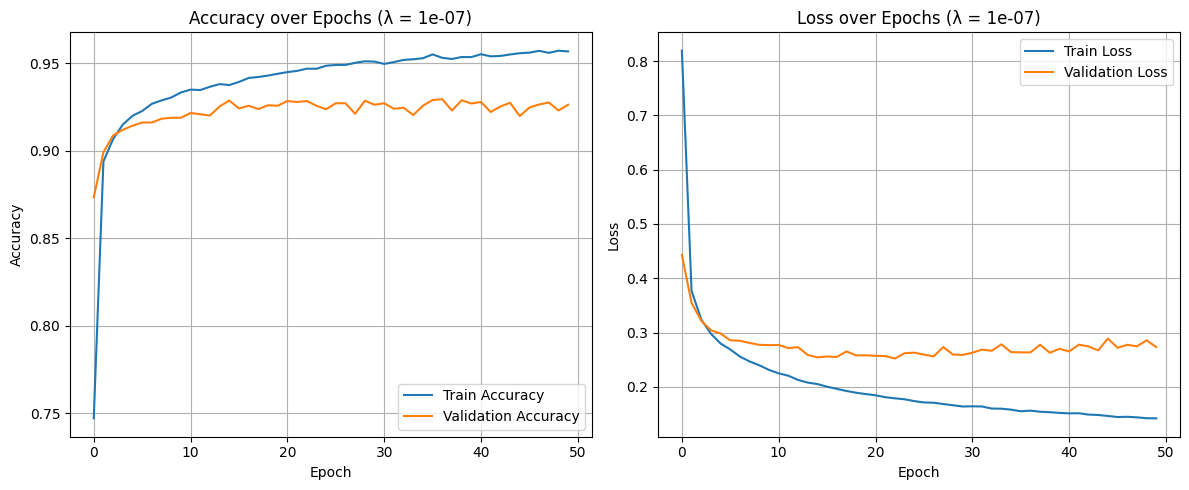

In [11]:
# Plot Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_M1_L1.history['accuracy'], label='Train Accuracy')
plt.plot(history_M1_L1.history['val_accuracy'], label='Validation Accuracy')
plt.title(f'Accuracy over Epochs (λ = {lambda_val})')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history_M1_L1.history['loss'], label='Train Loss')
plt.plot(history_M1_L1.history['val_loss'], label='Validation Loss')
plt.title(f'Loss over Epochs (λ = {lambda_val})')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [21]:
def train_model_with_l1(lambda_val):
    model = keras.Sequential([
        layers.Dense(8, activation='relu', input_shape=(784,),
                     kernel_regularizer=regularizers.l1(lambda_val)),
        layers.Dense(16, activation='relu',
                     kernel_regularizer=regularizers.l1(lambda_val)),
        layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(x_train, y_train,
                        epochs=50,
                        batch_size=32,
                        validation_data=(x_val, y_val),
                        verbose=0)

    # Evaluate on test set
    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)

    # Extract final metrics
    train_acc = history.history['accuracy'][-1]
    val_acc   = history.history['val_accuracy'][-1]
    val_loss  = history.history['val_loss'][-1]

    return lambda_val, train_acc, val_acc, val_loss, test_loss


In [22]:
lambda_values = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
results = []
# Grid search
for lmbd in lambda_values:
    result = train_model_with_l1(lmbd)
    results.append(result)

In [23]:
# Print results
print("\n λ Grid Search Results:")
for lmbd, train_acc, val_acc, val_loss, test_loss in results:
    gap = train_acc - val_acc
    print(f"  λ = {lmbd:.0e} | Train Acc = {train_acc:.4f} | Val Acc = {val_acc:.4f} | Gap = {gap:.4f}")

# Sort by best val accuracy with smallest overfitting
results_sorted = sorted(results, key=lambda x: (-x[2], abs(x[1] - x[2])))
best_lambda = results_sorted[0][0]

print(f"\n Optimal λ found: λ_opt = {best_lambda:.0e}")


 λ Grid Search Results:
  λ = 1e-06 | Train Acc = 0.9587 | Val Acc = 0.9281 | Gap = 0.0305
  λ = 1e-05 | Train Acc = 0.9467 | Val Acc = 0.9183 | Gap = 0.0284
  λ = 1e-04 | Train Acc = 0.9491 | Val Acc = 0.9273 | Gap = 0.0218
  λ = 1e-03 | Train Acc = 0.9291 | Val Acc = 0.9199 | Gap = 0.0092
  λ = 1e-02 | Train Acc = 0.8817 | Val Acc = 0.8856 | Gap = -0.0039
  λ = 1e-01 | Train Acc = 0.1129 | Val Acc = 0.1126 | Gap = 0.0004

 Optimal λ found: λ_opt = 1e-06


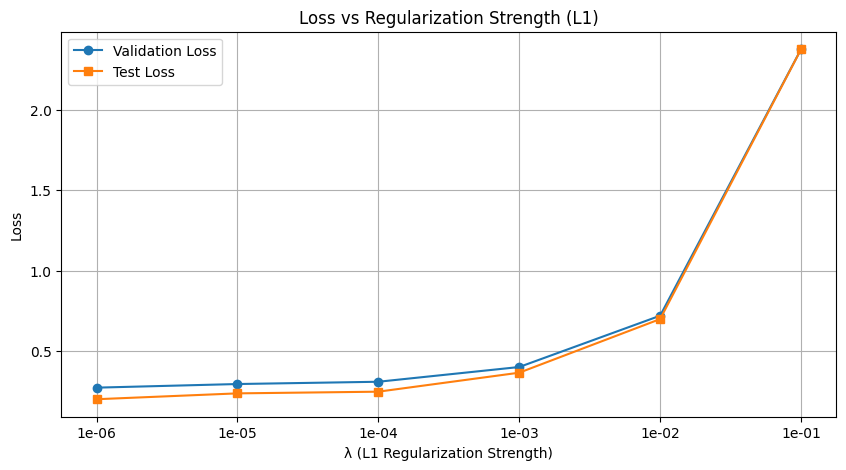

In [24]:
# Plot val/test loss vs lambda (log scale)
lambda_strs = [f"{l:.0e}" for l in lambda_values]
val_losses = [res[3] for res in results]
test_losses = [res[4] for res in results]

plt.figure(figsize=(10, 5))
plt.plot(lambda_strs, val_losses, marker='o', label='Validation Loss')
plt.plot(lambda_strs, test_losses, marker='s', label='Test Loss')
plt.xlabel("λ (L1 Regularization Strength)")
plt.ylabel("Loss")
plt.title("Loss vs Regularization Strength (L1)")
plt.legend()
plt.grid(True)
plt.show()

In [25]:
def train_model_with_l2(lambda_val):
    model = keras.Sequential([
        layers.Dense(8, activation='relu', input_shape=(784,),
                     kernel_regularizer=regularizers.l2(lambda_val)),
        layers.Dense(16, activation='relu',
                     kernel_regularizer=regularizers.l2(lambda_val)),
        layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(x_train, y_train,
                        epochs=50,
                        batch_size=32,
                        validation_data=(x_val, y_val),
                        verbose=0)

    # Evaluate on test set
    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)

    # Extract metrics
    train_acc = history.history['accuracy'][-1]
    val_acc   = history.history['val_accuracy'][-1]
    val_loss  = history.history['val_loss'][-1]

    return lambda_val, train_acc, val_acc, val_loss, test_loss

In [26]:
results_l2 = []
for lmbd in lambda_values:
    results_l2.append(train_model_with_l2(lmbd))

In [27]:
# Print results
print("\n L2 Grid Search Results:")
for lmbd, train_acc, val_acc, val_loss, test_loss in results_l2:
    gap = train_acc - val_acc
    print(f"  λ = {lmbd:.0e} | Train Acc = {train_acc:.4f} | Val Acc = {val_acc:.4f} | Gap = {gap:.4f}")


 L2 Grid Search Results:
  λ = 1e-06 | Train Acc = 0.9554 | Val Acc = 0.9206 | Gap = 0.0348
  λ = 1e-05 | Train Acc = 0.9573 | Val Acc = 0.9250 | Gap = 0.0323
  λ = 1e-04 | Train Acc = 0.9519 | Val Acc = 0.9236 | Gap = 0.0283
  λ = 1e-03 | Train Acc = 0.9440 | Val Acc = 0.9286 | Gap = 0.0154
  λ = 1e-02 | Train Acc = 0.9234 | Val Acc = 0.9154 | Gap = 0.0080
  λ = 1e-01 | Train Acc = 0.8847 | Val Acc = 0.8747 | Gap = 0.0100


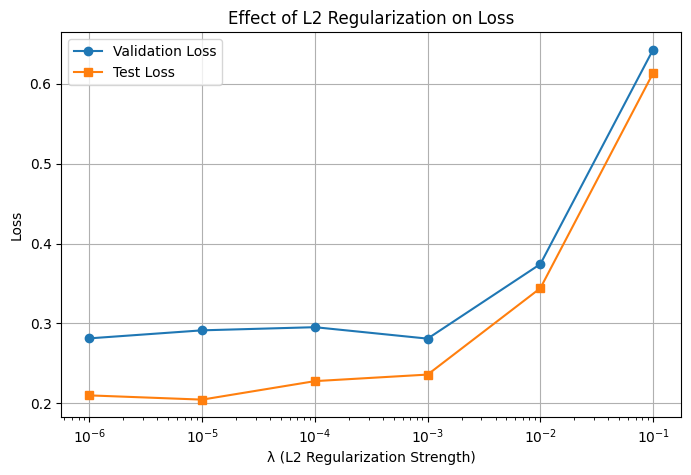

In [28]:
# Plot validation & test loss vs λ
lambdas = [r[0] for r in results_l2]
val_losses = [r[3] for r in results_l2]
test_losses = [r[4] for r in results_l2]

plt.figure(figsize=(8,5))
plt.plot(lambdas, val_losses, marker='o', label='Validation Loss')
plt.plot(lambdas, test_losses, marker='s', label='Test Loss')
plt.xscale('log')
plt.xlabel('λ (L2 Regularization Strength)')
plt.ylabel('Loss')
plt.title('Effect of L2 Regularization on Loss')
plt.legend()
plt.grid(True)
plt.show()

In [29]:
def train_model_l2_dropout(lambda_val, p):
    model = keras.Sequential([
        layers.Dense(8, activation='relu', input_shape=(784,),
                     kernel_regularizer=regularizers.l2(lambda_val)),
        layers.Dropout(p),
        layers.Dense(16, activation='relu',
                     kernel_regularizer=regularizers.l2(lambda_val)),
        layers.Dropout(p),
        layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(x_train, y_train,
                        epochs=50,
                        batch_size=32,
                        validation_data=(x_val, y_val),
                        verbose=0)

    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)

    train_acc = history.history['accuracy'][-1]
    val_acc = history.history['val_accuracy'][-1]
    val_loss = history.history['val_loss'][-1]

    return p, train_acc, val_acc, val_loss, test_acc


In [31]:
lambda_val = 1e-3

p_values = np.round(np.arange(0.01, 1.00, 0.05), 2)
results = []

In [32]:
for p in p_values:
    results.append(train_model_l2_dropout(lambda_val, p))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [37]:
# Print results
print("\n Dropout Grid Search Results (L2 λ = 1e-3):")
for p, train_acc, val_acc, val_loss, test_acc in results:
    gap = train_acc - val_acc
    print(f"  p = {p:.2f} | Train Acc = {train_acc:.4f} | Val Acc = {val_acc:.4f} | Gap = {gap:.4f} | Test Acc = {test_acc:.4f}")

# Select best p with highest validation accuracy and minimal overfitting
results_sorted = sorted(results, key=lambda x: (-x[2], abs(x[1] - x[2])))
p_opt = results_sorted[0][0]
val_opt = results_sorted[0][2]



 Dropout Grid Search Results (L2 λ = 1e-3):
  p = 0.01 | Train Acc = 0.9315 | Val Acc = 0.9363 | Gap = -0.0048 | Test Acc = 0.9430
  p = 0.06 | Train Acc = 0.8875 | Val Acc = 0.9126 | Gap = -0.0251 | Test Acc = 0.9240
  p = 0.11 | Train Acc = 0.8481 | Val Acc = 0.9049 | Gap = -0.0568 | Test Acc = 0.9186
  p = 0.16 | Train Acc = 0.8082 | Val Acc = 0.8963 | Gap = -0.0881 | Test Acc = 0.9058
  p = 0.21 | Train Acc = 0.7607 | Val Acc = 0.8794 | Gap = -0.1187 | Test Acc = 0.8925
  p = 0.26 | Train Acc = 0.7352 | Val Acc = 0.8737 | Gap = -0.1385 | Test Acc = 0.8881
  p = 0.31 | Train Acc = 0.6777 | Val Acc = 0.8760 | Gap = -0.1983 | Test Acc = 0.8870
  p = 0.36 | Train Acc = 0.6538 | Val Acc = 0.8424 | Gap = -0.1886 | Test Acc = 0.8585
  p = 0.41 | Train Acc = 0.5765 | Val Acc = 0.8166 | Gap = -0.2401 | Test Acc = 0.8275
  p = 0.46 | Train Acc = 0.5528 | Val Acc = 0.7914 | Gap = -0.2386 | Test Acc = 0.7988
  p = 0.51 | Train Acc = 0.4811 | Val Acc = 0.6900 | Gap = -0.2089 | Test Acc = 0.698


 Optimal Dropout Rate (p_opt) with highest val accuracy and minimal overfitting: p_opt = 0.01 (Val Acc = 0.9363)


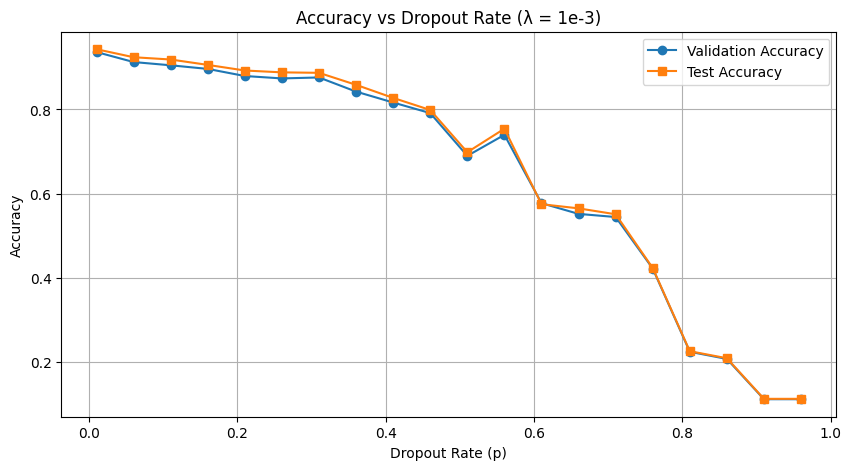

In [36]:
print(f"\n Optimal Dropout Rate (p_opt) with highest val accuracy and minimal overfitting: p_opt = {p_opt:.2f} (Val Acc = {val_opt:.4f})")

# Plot validation and test accuracy vs dropout rate
p_list = [res[0] for res in results]
val_acc_list = [res[2] for res in results]
test_acc_list = [res[4] for res in results]

plt.figure(figsize=(10, 5))
plt.plot(p_list, val_acc_list, marker='o', label='Validation Accuracy')
plt.plot(p_list, test_acc_list, marker='s', label='Test Accuracy')
plt.xlabel('Dropout Rate (p)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Dropout Rate (λ = 1e-3)')
plt.legend()
plt.grid(True)
plt.show()